In [1]:
import  tensorflow as tf
print("Tf version:", tf.__version__)

import itertools 

Tf version: 2.3.0


In [2]:
import tensorflow_hub as hub
print("Hub version:", hub.__version__)

Hub version: 0.12.0


In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     ac2e27fa8891e1d7a2ee88196a2a4223  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.shape

(10222, 2)

In [5]:

import matplotlib.pyplot as plt


In [6]:
import os
import numpy as np
from IPython.display import Image

In [7]:
# Checking given labels
labels_using=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug',
              'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']


In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
for index,breed in labels_csv.iterrows():
    if breed[1] not in labels_using:
        labels_csv=labels_csv.drop([index])
labels_csv.shape
        

(841, 2)

In [10]:
# Create pathnames from image ID's
filenames=["train/"+fname +".jpg"for fname in labels_csv["id"]]
filenames[:10]

['train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'train/008b1271ed1addaccf93783b39deab45.jpg',
 'train/00a366d4b4a9bbb6c8a63126697b7656.jpg',
 'train/0100f55e4f0fe28f2c0465d3fc4b9897.jpg',
 'train/01e787576c003930f96c966f9c3e1d44.jpg',
 'train/01f429667104c0c5a5f321700f15435c.jpg',
 'train/0206c12e8984e3c8a166cc272de25d6f.jpg',
 'train/023e4e28415506e0deddcbd8f8bdab29.jpg',
 'train/02508e76981e1ba059d785704b4c480c.jpg']

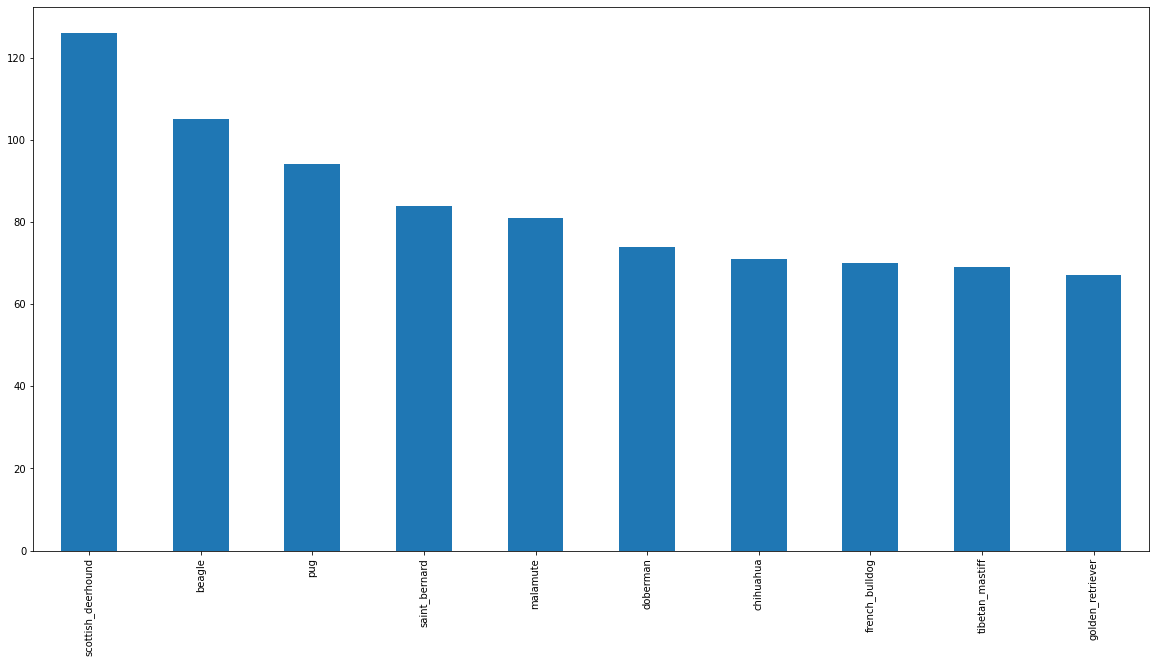

In [11]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

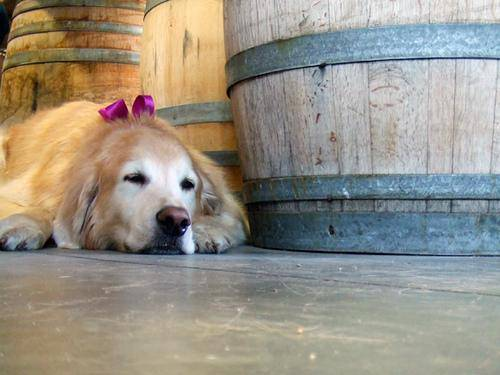

In [12]:
Image(filenames[10])

In [13]:
labels=np.array(labels_csv["breed"])
len(labels),labels

(841,
 array(['golden_retriever', 'scottish_deerhound', 'doberman',
        'golden_retriever', 'golden_retriever', 'scottish_deerhound',
        'malamute', 'chihuahua', 'pug', 'pug', 'golden_retriever',
        'saint_bernard', 'saint_bernard', 'scottish_deerhound', 'malamute',
        'doberman', 'doberman', 'beagle', 'scottish_deerhound',
        'scottish_deerhound', 'scottish_deerhound', 'pug', 'doberman',
        'doberman', 'pug', 'golden_retriever', 'scottish_deerhound',
        'chihuahua', 'french_bulldog', 'saint_bernard', 'malamute',
        'french_bulldog', 'tibetan_mastiff', 'tibetan_mastiff', 'malamute',
        'scottish_deerhound', 'beagle', 'scottish_deerhound', 'malamute',
        'golden_retriever', 'pug', 'doberman', 'beagle', 'tibetan_mastiff',
        'scottish_deerhound', 'malamute', 'beagle', 'beagle', 'chihuahua',
        'chihuahua', 'pug', 'scottish_deerhound', 'pug', 'malamute', 'pug',
        'beagle', 'french_bulldog', 'scottish_deerhound',
        'sco

In [14]:
# Turn labels into boolean labels
boolean_labels=[label==np.array(labels_using) for label in labels]
boolean_labels[:2]

[array([False, False, False, False,  True, False, False, False, False,
        False]),
 array([False, False, False, False, False, False, False, False,  True,
        False])]

## Creating training and validation set

In [15]:
x=filenames
y=boolean_labels

In [16]:
from matplotlib.pyplot import imread
image=imread(filenames[100])
image.shape

(382, 500, 3)

## Preprocessing Image

In [17]:
# Define image size
IMG_SIZE=224
 
# Create a function for preprocessing images
def process_image(image_path,img_size=IMG_SIZE):
    # Read in an image file
    image=tf.io.read_file(image_path)
    # Turn jpeg into numerical tensor with 3 colour channel(R,G,B)
    image=tf.image.decode_jpeg(image,channels=3)
    # Convert color channels value from 0-255 to 0-1 values
    image=tf.image.convert_image_dtype(image,tf.float32)
    # Resize the image to our desired value
    image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

    return image

In [18]:
# Create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
    image=process_image(image_path)
    return image,label


## Convert data into batches

In [45]:
BATCH_SIZE =32
# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches...")
        data=tf.data.Dataset.from_tensor_slices(tf.constant(x)) # only filepath no label
        data_batch=data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    elif valid_data:
        print("Creating valid data batches...")
        # Turn filepath and label into tensors
        data=tf.data.Dataset.from_tensor_slices((tf.constant(x),  
                                             tf.constant(y))) 
        data_batch=data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
  
    else:
        print("Creating training data batches...")
        data=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                             tf.constant(y)))
        # Shuffling the pathnames and labels  
        data=data.shuffle(buffer_size=len(x))
        data=data.map(get_image_label)
        data_batch=data.batch(BATCH_SIZE)
    return data_batch


In [20]:
# Create training and validation data batches
train_data=create_data_batches(x,y)


Creating training data batches...


In [21]:
# Create a function for viewing images in data batch
def show_25_images(images,labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax=plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(labels_using[labels[i].argmax()])
        plt.axis("off")

In [22]:
train_images,train_labels=next(train_data.as_numpy_iterator())


In [23]:
train_images,train_labels

(array([[[[4.80818152e-02, 7.50087574e-02, 9.80141312e-02],
          [6.27030879e-02, 7.44992942e-02, 9.41123813e-02],
          [6.79592565e-02, 6.40814602e-02, 8.36893022e-02],
          ...,
          [6.25638962e-01, 6.70054317e-01, 5.74615002e-01],
          [6.20378196e-01, 6.59593880e-01, 5.61554670e-01],
          [6.07843876e-01, 6.47059560e-01, 5.49020350e-01]],
 
         [[2.82142945e-02, 4.99019586e-02, 6.68819919e-02],
          [4.46726009e-02, 5.88129833e-02, 7.36904517e-02],
          [5.67051470e-02, 5.28273471e-02, 7.16385767e-02],
          ...,
          [6.28772736e-01, 6.73188090e-01, 5.77748775e-01],
          [6.25875413e-01, 6.65091097e-01, 5.67051888e-01],
          [6.13855183e-01, 6.53070867e-01, 5.55031657e-01]],
 
         [[3.79726887e-02, 5.36064468e-02, 6.53536469e-02],
          [5.88236153e-02, 6.27713203e-02, 7.84138665e-02],
          [6.92839697e-02, 6.53683022e-02, 8.49584416e-02],
          ...,
          [6.24798656e-01, 6.69214010e-01, 5.7378

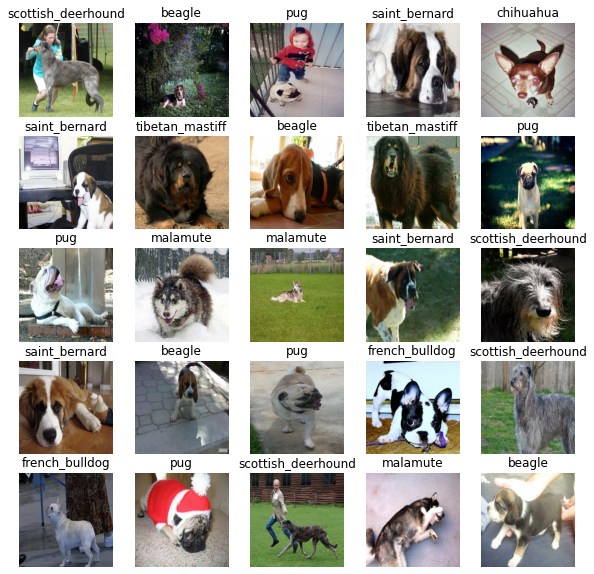

In [24]:
show_25_images(train_images,train_labels)

## Model building

In [25]:
# Setup input shape to the model
INPUT_SHAPE=[None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels 
# Setup output shape of our model
OUTPUT_SHAPE=len(labels_using)
# Setup model url from Tensorflow Hub
MODEL_URL="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"

In [26]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred): 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
# Create a function which build keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with", MODEL_URL)

    # Setup model layers
    model=tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
        activation="softmax") 

  ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy",f1_score]
  )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [28]:
model=create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25615849  
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)     

In [29]:
# Creating early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                patience=3)

In [30]:
model.fit(x=train_data,
            epochs=10,
            callbacks=[ early_stopping])
  

Epoch 1/10
27/27 [==============================] - 91s 3s/step - loss: 1.4594 - accuracy: 0.5945 - f1_score: 0.5865
Epoch 2/10
27/27 [==============================] - 93s 3s/step - loss: 0.6371 - accuracy: 0.8383 - f1_score: 0.8409
Epoch 3/10
27/27 [==============================] - 89s 3s/step - loss: 0.5024 - accuracy: 0.8597 - f1_score: 0.8644
Epoch 4/10
27/27 [==============================] - 86s 3s/step - loss: 0.3741 - accuracy: 0.8966 - f1_score: 0.9023
Epoch 5/10
27/27 [==============================] - 84s 3s/step - loss: 0.3423 - accuracy: 0.9049 - f1_score: 0.9093
Epoch 6/10
27/27 [==============================] - 83s 3s/step - loss: 0.1989 - accuracy: 0.9298 - f1_score: 0.9322
Epoch 7/10
27/27 [==============================] - 87s 3s/step - loss: 0.2309 - accuracy: 0.9417 - f1_score: 0.9441
Epoch 8/10
27/27 [==============================] - 84s 3s/step - loss: 0.2464 - accuracy: 0.9405 - f1_score: 0.9403
Epoch 9/10
27/27 [==============================] - 84s 3s/step 

In [31]:
test_path="test/"
test_filenames=[test_path + fnames for fnames in os.listdir(test_path)]
test_filenames[:10]

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'test/002f80396f1e3db687c5932d7978b196.jpg',
 'test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [32]:
# Create test data batch
test_data=create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [33]:
test_prediction= model.predict(test_data, 
                              verbose=1)

324/324 [==============================] - 1156s 4s/step


In [34]:
model.save("DogClassification_resnet_v2_50")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: DogClassification_resnet_v2_50\assets


INFO:tensorflow:Assets written to: DogClassification_resnet_v2_50\assets


In [35]:
np.savetxt('preds_array.csv', test_prediction, delimiter=",")

In [36]:
test_prediction.shape


(10357, 10)

In [39]:
preds_df=pd.DataFrame(columns=["id"] +list(labels_using))
test_ids=[os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"]= test_ids
preds_df[list(labels_using)]=test_prediction
preds_df.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,0.017518,0.003878,0.080671,0.029444,0.001469,0.021205,0.014014,0.184327,0.031566,0.615908
1,00102ee9d8eb90812350685311fe5890,0.000003,0.000001,0.000001,0.000002,0.000005,0.987939,0.0,0.000001,0.000012,0.012037
2,0012a730dfa437f5f3613fb75efcd4ce,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.999998,0.0
3,001510bc8570bbeee98c8d80c8a95ec1,0.001993,0.000146,0.004311,0.039774,0.000656,0.156715,0.623486,0.002222,0.000655,0.170043
4,001a5f3114548acdefa3d4da05474c2e,0.0,0.0,0.000008,0.000331,0.0,0.006942,0.033968,0.000054,0.000012,0.958685


# Loss,accuracy,F1_score,Confusion_matrix,roc-auc curve for test data 

* We can not evaluate test data because we dont have actual labels to compare with our predicted labels
so instead of evaluating on test_data i m evaluating on valid data but for demo I m evaluating on test data which gona show `Null`

In [49]:
## Demo
# Loss,accuracy,F1_score for test data 
loss,accuracy,f1_score=model.evaluate(test_data)
print("Loss: ",loss)
print("Accuracy: ",accuracy)
print("F1_score: ",f1_score)

324/324 [==============================] - 54s 166ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00
Loss:  0.0
Accuracy:  0.0
F1_score:  0.0


In [50]:
# Now evaluating on valid data
x_val,y_val=x[671:841],y[671:841]
val_data=create_data_batches(x_val,y_val,valid_data=True )


Creating valid data batches...


In [48]:
# Loss,accuracy,F1_score for valid data 
loss,accuracy,f1_score=model.evaluate(val_data)
print("Loss: ",loss)
print("Accuracy: ",accuracy)
print("F1_score: ",f1_score)

6/6 [==============================] - 15s 3s/step - loss: 0.0137 - accuracy: 0.9941 - f1_score: 0.9948
Loss:  0.013662402518093586
Accuracy:  0.9941176176071167
F1_score:  0.9947916865348816
